In [5]:
# importing necessary libraries
import numpy as np
import scipy as sp
import scipy.integrate as sint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import integrate
from scipy import interpolate
from IPython import display
plt.rcParams['figure.figsize'] = [10, 10]
plt.close('all')
pi = np.pi

In [6]:
# Set longitudinal growth parameters
theta0 = -pi/4 # Initial angle [1]
T = 1e8 # Final time [s]
l0 = 1 # Initial length [cm]
L = 50 # Final length [cm]
vl = (L-l0)/T # Growth speed [cm/s]

# Set radial growth parameters
alpha = 0.01
gamma = 1.5
r0 = 0.15 # Initial radius at growing tip [cm]

# Set the step size of eta and t (used for numerical solver)
acc_eta = 1e-3
acc_t = 1e-3
n_eta = int(1/acc_eta + 1) # Number of eta increments
n_t = int(1/acc_t + 1) # Number of time increments
d_eta = 1/(n_eta - 1) # eta increment size
d_t = T/(n_t - 1) # time increment size

# Set material parameters (using params of Yamamoto et al. 2002)
rhog = 1.5  # gf / cm^3
E =  48*1e3 # kgf / cm^2

# Set control parameters
epsmax = 0.005
ctrltype = 2
thetaP = pi/4

# Initialize space
eta = np.linspace(0, 1, n_eta)
theta_intr = np.zeros(n_eta)
theta = theta0*np.ones(n_eta)

# Frames used to calculate coordinates and output videos
# Dont set this too high! not really necessary
frames = range(0,n_t,int(1/acc_t/1000))

### Setting the radial growth rule

We assume

$$ r(s,t) = r_0 + \alpha (l - s)^\gamma $$

because it makes sense to let $r(s,t)$ be a function of $l-s$ which is equivalent to how much time has passed since radial growth started at that point $s$. 
We also make this non-dimensional by setting $R(\eta, t) = r(s,t) / l(t)$, and we have

$$ R(\eta, t) = \dfrac{r_0}{l} + \alpha l^{\gamma - 1} (1 - \eta)^\gamma $$


### Governing equation of the branch

The governing equation of the branch is

$$ \dfrac{E}{4 \pi} \partial_s \left[ r^4 (\kappa - \kappa_g) \right] = \rho g \cos{\theta} \int_s^l \pi r^2 \, d\tilde{s} $$

Where $\kappa(s,t) = \partial_s \theta(s,t)$ is the actual curvature, and $\kappa_g(s,t) = \partial_s \theta_g(s,t)$ is the intrinsic curvature.
The boundary conditions are: $\theta(0,t) = \theta_0$ (clamped end) and $\kappa(l,t) = \kappa_g(l,t)$ (free end).

Making the system non-dimensional, it becomes

$$ \left[ R^4 (K - K_g) \right]' = \dfrac{4 \pi^2 \rho g l}{E} \cos{\Theta} \int_\eta^1 R^2 \, d\tilde{\eta} $$

where $(\cdot)' = \partial_\eta (\cdot)$, and $K = \Theta', K_g = \Theta_g'$

with the boundary conditions $\Theta(0,t) = \theta_0$ and $K(1,t) = K_g(1,t)$.


### Evolution of the intrinsic curvature

The evolution equation of the intrinsic curvature is

$$ \dot{\kappa_g} = 4 \dfrac{\dot{r}}{r} (\kappa - \kappa_g) + 48 \pi \dfrac{\dot{r}}{r^2} \epsilon(\theta) $$

The first term comes from the fact that, the newly added layers will have the current curvature of the branch as its intrinsic curvature.
The second term is the reaction wood term, with some growth strain $\epsilon(\theta)$ accounting for posture control.
In this program we have several types of this control function.

Making the system dimensionless gives:

$$ \dot{K_g} = \dfrac{\dot{l}}{l} (K_g - \eta \, \partial_\eta K_g) + \left[ \dfrac{\dot{l}}{l} (1 - \eta R) + \dfrac{\dot{R}}{R} \right] \left[ 4 \left(K - K_g\right) + \dfrac{48 \pi \epsilon(\Theta)}{R} \right] $$

It is important to note that the two time partial derivatives in $\dot{\kappa_g}$ and $\dot{K_g}$ are not the same, because the latter means to take the derivative with $\eta$ fixed.

### Summary

The main equations to be solved are:

\begin{align}
  \Theta' &= K \\
  \left[ R^4 (K - K_g) \right]' &= \dfrac{4 \pi^2 \rho g l}{E} \cos{\Theta} \int_\eta^1 R^2 \, d\tilde{\eta} \\
  \dot{K_g} &= \dfrac{\dot{l}}{l} (K_g - \eta \, \partial_\eta K_g) + \left[ \dfrac{\dot{l}}{l} (1 - \eta R) + \dfrac{\dot{R}}{R} \right] \left[ 4 \left(K - K_g\right) + \dfrac{48 \pi \epsilon(\Theta)}{R} \right] \\
  R &= \dfrac{r_0}{l} + \alpha l^{\gamma - 1} (1 - \eta)^\gamma
\end{align}

with 

$$ \Theta(0,t) = \theta_0, \; K(1,t) = K_g(1,t), \; K_g(0,t) = 0 $$

In [7]:
# Define r(s,t) (but as r(eta, t))
def r(eta, r0, l, alpha, gamma):
  return r0 + alpha*(l*(1-eta))**gamma

# Define R(eta,t)
def R(eta, r0, l, alpha, gamma):
  return r0/l + alpha*l**(gamma-1)*(1-eta)**gamma

# Define space derivative of R(eta,t)
def dRdeta(eta, r0, l, alpha, gamma):
  return -alpha*gamma*l**(gamma-1)*(1-eta)**(gamma-1)

# Define time derivative of R(eta,t)
def dRdt(eta, r0, l, alpha, gamma):
  return -r0*vl*l**(-2) + alpha*(gamma-1)*vl*l**(gamma-2)*(1-eta)**gamma

# Calculate the integral term of R^2 on the right hand side
def intRsq(eta, r0, l, alpha, gamma):
  return (r0/l)**2 * (1-eta) + alpha**2 * l**(2*(gamma-1)) / (2*gamma+1) * (1-eta)**(2*gamma+1) + 2*alpha*r0*l**(gamma-2)/(gamma+1) * (1-eta)**(gamma+1)

# Define control epsilon
def epsilon(epsmax,ctrltype,theta,thetaP=pi/4):
  if ctrltype == 0:
    return 0*theta
  if ctrltype == 1:
    return epsmax * (theta < thetaP) + 0 * (theta >= thetaP)
  if ctrltype == 2:
    return - epsmax * np.sin(theta - thetaP)

# Define updating function for intrinsic curvature K_g
def updateK(eta,K,theta,t,d_t,vl,l,epsmax,ctrltype,thetaP):
  d_theta = np.gradient(theta,eta)
  rad = R(eta, r0, l, alpha, gamma)
  drad = dRdeta(eta, r0, l, alpha, gamma)
  radot = dRdt(eta, r0, l, alpha, gamma)
  dK = vl/l*(K - eta*np.gradient(K_interp(eta))) + (vl/l*(1-eta*drad) + radot/rad) * (4*(d_theta-K) + 48*pi*epsilon(epsmax, ctrltype, theta)/rad)
  return K + dK*d_t

# Define the main equililbrium equation
def equil(eta,y):
  global t, r0, l, alpha, gamma, rhog, E
  theta, omega = y
  rad = R(eta, r0, l, alpha, gamma)
  drad = dRdeta(eta, r0, l, alpha, gamma)
  irad = intRsq(eta, r0, l, alpha, gamma)
  eq = np.vstack((omega, np.gradient(K_interp(eta)) - 4*drad/rad * (omega - K_interp(eta))+ 4*rhog*l*pi*pi/E/rad**4 * np.cos(theta) * irad))
  return eq

# Define the boundary conditions
def bc(ya, yb):
  global theta0, K_interp, l0, l
  return np.array([ya[0] - theta0, yb[1] - K_interp(1)])

# Plotting function
def areaplot(ax,x,y,theta,r,color='k',ticks=101):
  N = len(x)
  intrv = int(np.floor((N-1)/(ticks-1)))
  indices = list(range(0,N,intrv))
  X_top = np.take(x - r/2 * np.sin(theta), indices)
  X_bot = np.take(x + r/2 * np.sin(theta), indices)
  Y_top = np.take(y + r/2 * np.cos(theta), indices)
  Y_bot = np.take(y - r/2 * np.cos(theta), indices)
  ax.plot([X_top[0],X_bot[0]],[Y_top[0],Y_bot[0]],color=color,alpha=0.7)
  ax.plot([X_top[-1],X_bot[-1]],[Y_top[-1],Y_bot[-1]],color=color,alpha=0.7)
  ax.plot(X_top, Y_top, color=color, alpha=0.7)
  ax.plot(X_bot, Y_bot, color=color, alpha=0.7)
  ax.plot(x,y, color=color,)

In [9]:
# Main cell - - - 
# Run this cell to obtain the solutions
# Theta, K, Kg and r
# (About 20 secs)

ts = np.linspace(0,T,n_t)

K_matrix = np.zeros((n_t,n_eta))
theta_matrix = np.zeros((n_t,n_eta))
dtheta_matrix = np.zeros((n_t,n_eta))
radius_matrix = np.zeros((n_t,n_eta))
theta_init = -0.1*np.ones((2,n_eta))

K = np.zeros(n_eta)
K_interp = interpolate.interp1d(eta, K)

for it in range(n_t):
  t = d_t*it
  l = l0 + vl*t
  sol = integrate.solve_bvp(equil, bc, eta, theta_init)
  theta = sol.y[0,:]
  dtheta = sol.y[1,:]
  theta_matrix[it,:] = theta
  dtheta_matrix[it,:] = dtheta
  radius_matrix[it,:] = r(eta, r0, l, alpha, gamma)
  K = updateK(eta,K,theta,t,d_t,vl,l,epsmax,ctrltype,thetaP)
  K_interp = interpolate.interp1d(eta, K)
  K_matrix[it,:] = K

In [10]:
# Obtain the coordinate information using the Theta(eta,t) obtained
# Obtain those information only for the time frames specified in the beginning - otherwise too much computation
# (About 5 mins)

coord = np.zeros((2*n_t,n_eta))
for it in frames:
  t = d_t * it
  l = l0 + vl*t
  theta = interpolate.interp1d(eta, theta_matrix[it,:])
  for i in range(n_eta):
    a = 0
    b = eta[i]
    intrv = np.linspace(a,b,129)
    theta_domain = theta(intrv)
    coord[2*it,i] = np.nan_to_num(l*integrate.simpson(np.cos(theta_domain),intrv))
    coord[2*it+1,i] = np.nan_to_num(l*integrate.simpson(np.sin(theta_domain),intrv))


/Users/teratsujikanademe/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:414: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/teratsujikanademe/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:416: RuntimeWarning: invalid value encountered in true_divide
  y[slice1] * (hsum * hsum / hprod) +


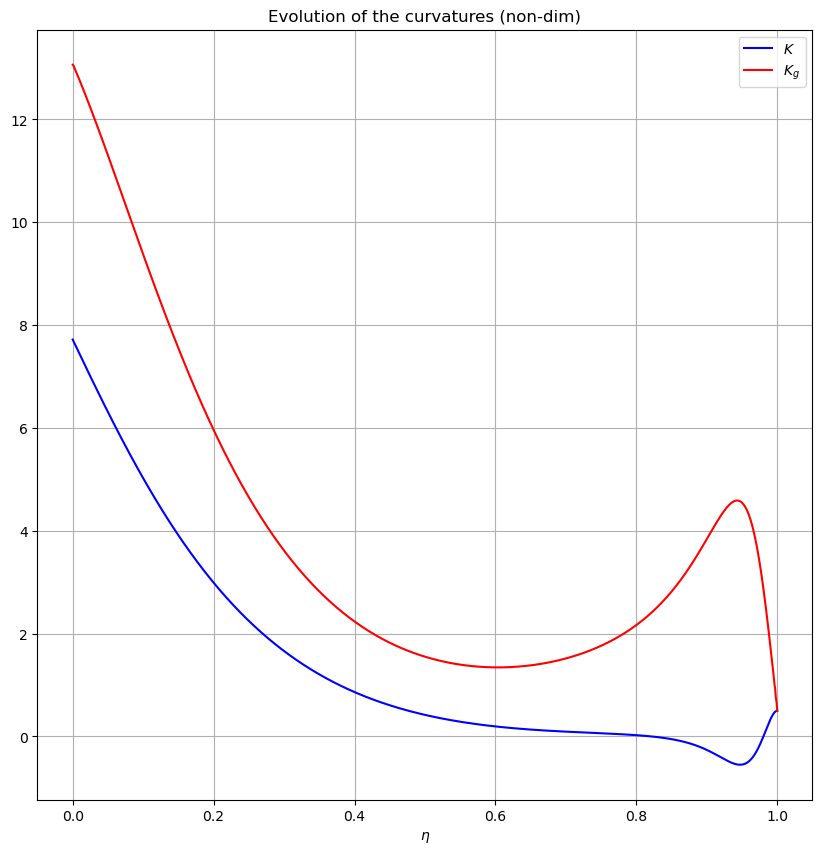

In [11]:
# Draw the final curvatures (at time T)
# Also store the final graph axes information

figT, axT = plt.subplots()
axT.set_title(r'Evolution of the curvatures (non-dim)')
axT.set_xlabel(r'$\eta$')
axT.plot(eta,dtheta_matrix[frames[-1],:],color='b',label=r"$K$")
axT.plot(eta,K_matrix[frames[-1],:],color='r',label=r"$K_g$")
axT.grid()
axT.legend()
xlim = axT.get_xlim()
ylim = axT.get_ylim()

In [7]:
# (Optional) Animate the evolution of curvatures and save as mp4
# (About 3 mins)

figanim, axanim = plt.subplots()

def update(frame):
  global figanim, axanim, xlim, ylim, theta_matrix, K_matrix
  axanim.cla()
  axanim.set_title(r'Evolution of the curvatures (non-dim)')
  axanim.set_xlabel(r'$\eta$')
  axanim.set_xlim(xlim[0],xlim[1])
  axanim.set_ylim(ylim[0],ylim[1])
  axanim.grid()
  axanim.plot(eta,dtheta_matrix[frame,:],color='b',label=r'$K$')
  axanim.plot(eta,K_matrix[frame,:],color='r',label=r'$K_g$')
  axanim.legend("bottomright")
  

ani = animation.FuncAnimation(figanim, update, frames, interval=40, repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
ani.save('crvs_nondim.mp4', writer=writervideo)
plt.close()

/var/folders/y7/00rktxln7550gdkzz1mhj5040000gn/T/ipykernel_78456/1996806626.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figT.show()


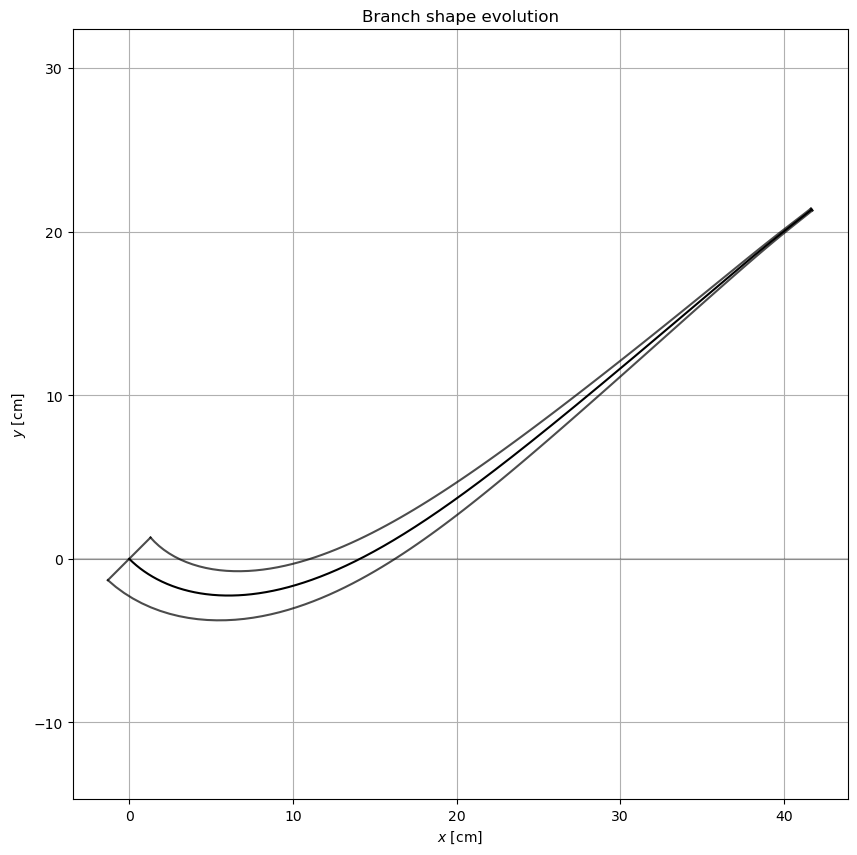

In [8]:
# Draw the final branch shape (at time T)
# Also store the final graph axes information

figT, axT = plt.subplots()
axT.set_title("Branch shape evolution")
axT.set_xlabel(r'$x$ [cm]')
axT.set_ylabel(r'$y$ [cm]')
axT.axhline(color='k',alpha=0.2)
#axT.axis('equal')
areaplot(axT,coord[2*frames[-1],:],coord[2*frames[-1]+1,:],theta_matrix[frames[-1],:],radius_matrix[frames[-1],:],color='k')
axT.grid()
axT.axis('equal')
xlim = axT.get_xlim()
ylim = axT.get_ylim()
figT.show()

In [9]:
# (Optional) Animate the branch shape
# (About 3 mins)

figanim, axanim = plt.subplots()

def update(frame):
  global figanim, axanim, xlim, ylim, coord, theta_matrix, radius_matrix
  axanim.cla()
  axanim.set_title("Branch shape evolution")
  axanim.set_xlabel(r'$x$ [cm]')
  axanim.set_ylabel(r'$y$ [cm]')
  axanim.axhline(color='k',alpha=0.2)
  axanim.grid()
  axanim.axis('equal')
  areaplot(axanim,coord[2*frame,:],coord[2*frame+1,:],theta_matrix[frame,:],radius_matrix[frame,:])
  axanim.set_xlim(xlim[0],xlim[1])
  axanim.set_ylim(ylim[0],ylim[1])

ani = animation.FuncAnimation(figanim, update, frames, interval=40, repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
ani.save('shape.mp4', writer=writervideo)
plt.close()

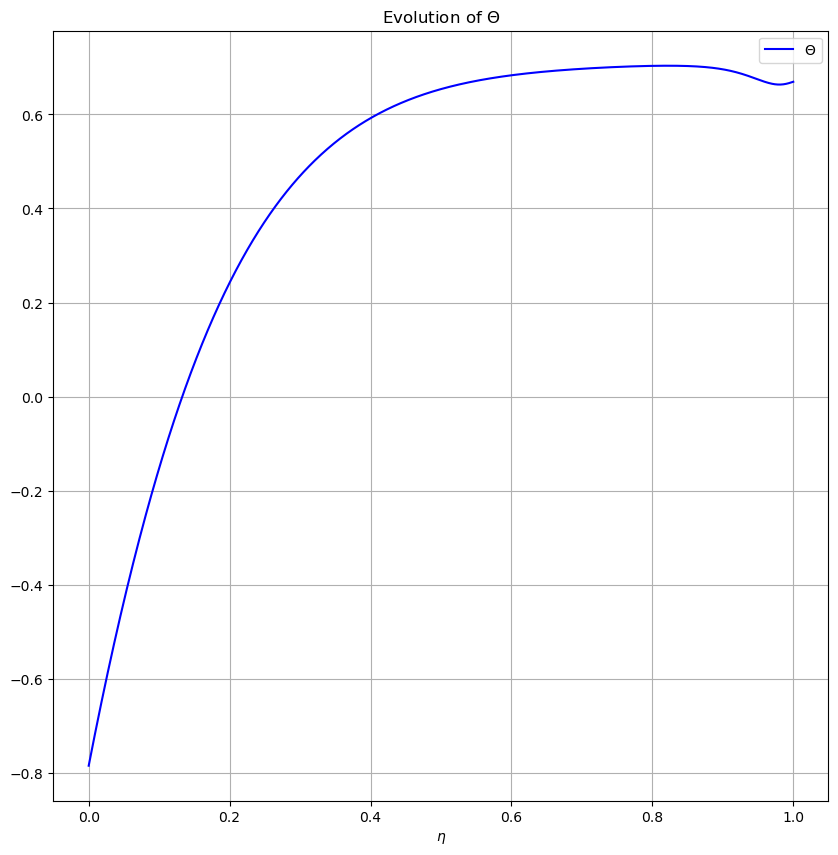

In [10]:
# Draw the final Theta distribution (at time T)
# Also store the final graph axes information

figT, axT = plt.subplots()
axT.set_title(r'Evolution of $\Theta$')
axT.set_xlabel(r'$\eta$')
axT.plot(eta,theta_matrix[frames[-1],:],color='b',label=r"$\Theta$")
axT.grid()
axT.legend()
xlim = axT.get_xlim()
ylim = axT.get_ylim()

In [11]:
# (Optional) Animate Theta evolution
# (About 3 mins)

figanim, axanim = plt.subplots()

def update(frame):
  global figanim, axanim, xlim, ylim, theta_matrix, K_matrix
  axanim.cla()
  axanim.set_title(r'Evolution of $\Theta$')
  axanim.set_xlabel(r'$\eta$')
  axanim.set_xlim(xlim[0],xlim[1])
  axanim.set_ylim(ylim[0],ylim[1])
  axanim.grid()
  axanim.hlines(pi/2,xlim[0],xlim[1])
  axanim.plot(eta,theta_matrix[frame,:],color='b',label=r'$\Theta$')
  axanim.legend("bottomright")
  

ani = animation.FuncAnimation(figanim, update, frames, interval=40, repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
ani.save('Theta.mp4', writer=writervideo)
plt.close()

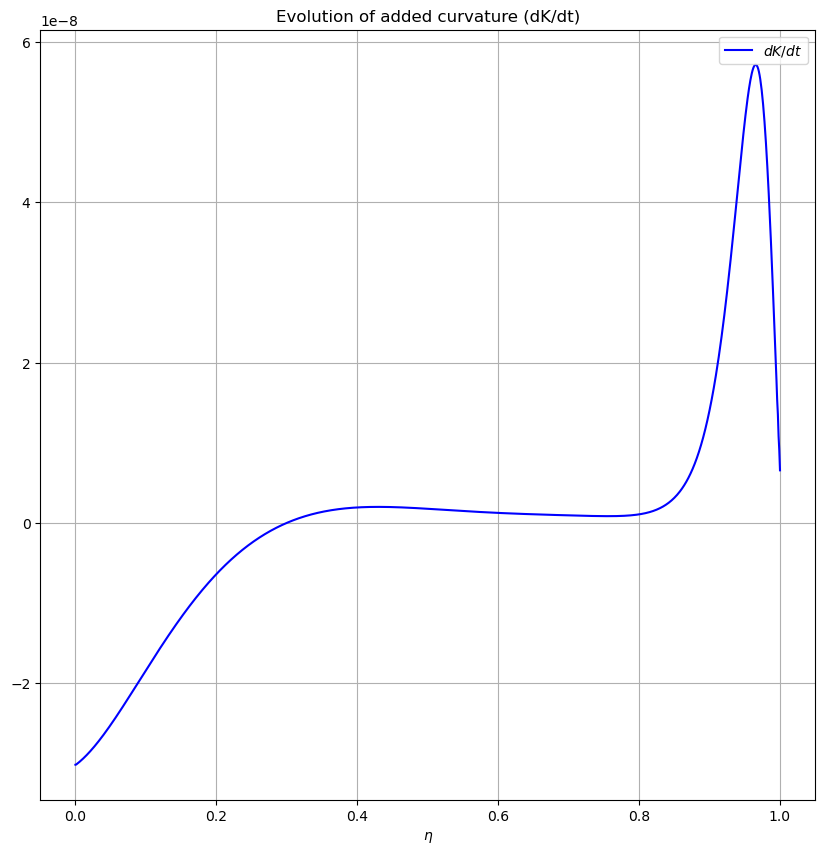

In [12]:
# Draw the how much intrinsic curvature is added
# Also store the final graph axes information

figT, axT = plt.subplots()
axT.set_title(r'Evolution of added curvature ($dK_g$)')
axT.set_xlabel(r'$\eta$')
axT.plot(eta,(K_matrix[frames[-1],:]-K_matrix[frames[-2],:])/d_t,color='b',label=r"$dK_g$")
axT.grid()
axT.legend()
xlim = axT.get_xlim()
ylim = axT.get_ylim()

In [13]:
# (Optional) Animate dK_g evolution
# (About 3 mins)

figanim, axanim = plt.subplots()

def update(frame):
  global figanim, axanim, xlim, ylim, K_matrix
  axanim.cla()
  axanim.set_title(r'Evolution of added curvature (dK_g)')
  axanim.set_xlabel(r'$\eta$')
  axanim.set_xlim(xlim[0],xlim[1])
  axanim.set_ylim(ylim[0],ylim[1])
  axanim.grid()
  axanim.plot(eta,(K_matrix[frame,:]-K_matrix[max(frame-1,0),:])/d_t,color='b',label=r"$dK_g$")
  axanim.legend("bottomright")
  

ani = animation.FuncAnimation(figanim, update, frames, interval=40, repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
ani.save('dK.mp4', writer=writervideo)
plt.close()